# Detecting capital letters and numbers

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.version.VERSION)
import tensorflowjs as tfjs

import math
import os

2.18.0


C:\Users\Hussain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tensorflowjs\read_weights.py:28: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  np.uint8, np.uint16, np.object, np.bool]


AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

## Subfunctions

In [2]:
# Need to know the start-stop index
def get_start_stop_index(Y):
    from collections import Counter
    c = Counter(Y)
    
    class_num_list = list(c.keys())
    class_num = len(class_num_list)
    print('class_num: ', class_num)
    
    st = [0]
    stop = []
    for i, val in enumerate(range(min(class_num_list), max(class_num_list)+1, 1)):
        if i > 0:
            st.append(stop[i-1]+1)
        stop.append((st[i] + c[val]) - 1)
        # print('i:', i, ', st: ', st[i], ', stop: ', stop[i])
    print('st: ', st)
    print('stop: ', stop)
    
    return st, stop, class_num

In [3]:
def select_first_num_of_sequentiallysorted_images(first_num, st, X, Y, offset):
    
    # Start from a certain offset from the first value of a certain class
    st_mod = [i+offset for i in st]
    
    # Select first first_num=1000, from an offset, for each number
    stop_mod = [i+first_num+offset for i in st]

    print('st_mod: ', st_mod)
    print('stop_mod: ', stop_mod)
    
    X_len = len(np.array(X).shape)
    if X_len == 3:
        X_shape = "2d_image"
    else:
        X_shape = "1d_vec"
    
    X_selected = []
    y_selected = []

    for i, st_val in enumerate(st_mod):
        for j in range(st_val, stop_mod[i], 1):
            
            if X_shape == "2d_image":
                # if X is already shape (-1, 28, 28)
                X_selected.append(X[j])
            else:
                # if X is shape (1, 784)
                X_selected.append(X.iloc[j,0:784].values.reshape(28,28))
                
            y_selected.append(Y[j])
            
    # Verify shape
    X_temp = np.array(X_selected)
    y_temp = np.array(y_selected)

    print('X_selected.shape: ', X_temp.shape)
    print('y_selected.shape: ', y_temp.shape)

    return X_selected, y_selected

In [4]:
def plotting_training_results(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize = (8, 8))

    ax0.plot(acc, label='Training Accuracy')
    ax0.plot(val_acc, label='Validation Accuracy')
    ax0.legend(loc='lower right')
    ax0.set_ylabel('Accuracy')
    ax0.set_ylim([0, 1])
    ax0.set_title(f'Training and Validation Accuracy: train={np.max(acc)}, val={np.max(val_acc)}')

    ax1.plot(loss, label='Training Loss')
    ax1.plot(val_loss, label='Validation Loss')
    ax1.legend(loc='upper right')
    ax1.set_ylabel('Loss/Cross Entropy')
    ax1.set_ylim([0, max(loss)])
    ax1.set_title(f'Training and Validation Loss: train={np.min(loss)}, val={np.min(val_loss)}')
    ax1.set_xlabel('epoch')

    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

    fig.savefig('/kaggle/working/accuracy_loss_results.jpg')

## Load numbers data

In [5]:
# Loading the dataset using Tensorflow enterprise version 2.2.0 or higher
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.load_data()

# Kaggle does not use enterprise version, it uses the regular version up-to-date (2.13.0).
# So load the dataset using keras, if one is not using Tensorflow enterprise.

from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [6]:
# Sort dataset by label number
ind = np.argsort(train_labels)
train_images_sortedbylet = [train_images[i] for i in ind]
train_labels_sortedbylet = [train_labels[i] for i in ind]

ind = np.argsort(test_labels)
test_images_sortedbylet = [test_images[i] for i in ind]
test_labels_sortedbylet = [test_labels[i] for i in ind]

In [7]:
# View the shape of the data
print('train_images_sortedbylet.shape: ', np.array(train_images_sortedbylet).shape)
print('train_labels_sortedbylet.shape: ', np.array(train_labels_sortedbylet).shape)
print('test_images_sortedbylet.shape: ', np.array(test_images_sortedbylet).shape)
print('test_labels_sortedbylet.shape: ', np.array(test_labels_sortedbylet).shape)

train_images_sortedbylet.shape:  (60000, 28, 28)
train_labels_sortedbylet.shape:  (60000,)
test_images_sortedbylet.shape:  (10000, 28, 28)
test_labels_sortedbylet.shape:  (10000,)


In [8]:
st_train, stop_train, class_num = get_start_stop_index(train_labels_sortedbylet)
st_test, stop_test, class_num = get_start_stop_index(test_labels_sortedbylet)

class_num:  10
st:  [0, 5923, 12665, 18623, 24754, 30596, 36017, 41935, 48200, 54051]
stop:  [5922, 12664, 18622, 24753, 30595, 36016, 41934, 48199, 54050, 59999]
class_num:  10
st:  [0, 980, 2115, 3147, 4157, 5139, 6031, 6989, 8017, 8991]
stop:  [979, 2114, 3146, 4156, 5138, 6030, 6988, 8016, 8990, 9999]


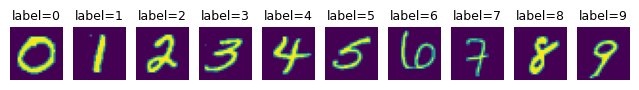

In [9]:
# Verify if mapping of images and labels are correct
fig, axx = plt.subplots(nrows=1, ncols=class_num, figsize=(8,8))

for i in range(class_num):
    axx[i].imshow(train_images_sortedbylet[st_train[i]])
    axx[i].axis('off')

    axx[i].set_title(f"label={train_labels_sortedbylet[st_train[i]]}", size=9)
plt.show()

In [10]:
# Select first 1000 of train data for each class_number
offset = 0
X_train_selected_num, y_train_selected_num = select_first_num_of_sequentiallysorted_images(1000, st_train, 
                                                                                   train_images_sortedbylet, 
                                                                                   train_labels_sortedbylet, offset)

# Select first 500 of test data for each class_number
X_test_selected_num, y_test_selected_num = select_first_num_of_sequentiallysorted_images(500, st_test, 
                                                                                 test_images_sortedbylet, 
                                                                                 test_labels_sortedbylet, offset)

st_mod:  [0, 5923, 12665, 18623, 24754, 30596, 36017, 41935, 48200, 54051]
stop_mod:  [1000, 6923, 13665, 19623, 25754, 31596, 37017, 42935, 49200, 55051]
X_selected.shape:  (10000, 28, 28)
y_selected.shape:  (10000,)
st_mod:  [0, 980, 2115, 3147, 4157, 5139, 6031, 6989, 8017, 8991]
stop_mod:  [500, 1480, 2615, 3647, 4657, 5639, 6531, 7489, 8517, 9491]
X_selected.shape:  (5000, 28, 28)
y_selected.shape:  (5000,)


## Load letters data

In [12]:
X = pd.read_csv("C:/Users/Hussain/Downloads/A_Z Handwritten Data.csv/tensorflowjs-letter-number-writing.ipynb")
X

# It is already sorted by label (X['0'])

FileNotFoundError: [Errno 2] No such file or directory: '/A_Z Handwritten Data.csv'

In [12]:
# Make X and y datasets
y = X.pop('0')

In [13]:
# View the shape of the data
print('X.shape: ', np.array(X).shape)
print('y.shape: ', np.array(y).shape)

X.shape:  (372450, 784)
y.shape:  (372450,)


In [14]:
st_caplet, stop_caplet, class_num_caplet = get_start_stop_index(y)

class_num:  26
st:  [0, 13869, 22537, 45946, 56080, 67520, 68683, 74445, 81663, 82783, 91276, 96879, 108465, 120801, 139811, 197636, 216977, 222789, 234355, 282774, 305269, 334277, 338459, 349243, 355515, 366374]
stop:  [13868, 22536, 45945, 56079, 67519, 68682, 74444, 81662, 82782, 91275, 96878, 108464, 120800, 139810, 197635, 216976, 222788, 234354, 282773, 305268, 334276, 338458, 349242, 355514, 366373, 372449]


In [15]:
y_sorted = [i+10 for i in y] # Offset label to go after class_number, A=10, B=11, ..., Z=35

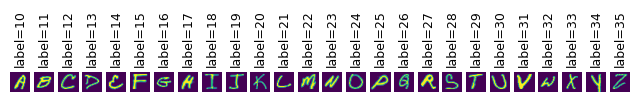

In [16]:
# Verify if mapping of images and labels are correct
fig, axx = plt.subplots(nrows=1, ncols=class_num_caplet, figsize=(8,8))

for i in range(class_num_caplet):
    axx[i].imshow(X.iloc[st_caplet[i],0:784].values.reshape(28,28))
    axx[i].axis('off')

    axx[i].set_title(f"label={y_sorted[st_caplet[i]]}", size=9, rotation=90)
plt.show()

In [17]:
# Select first 1000 of data for each class_number, for the train dataset
offset = 0
X_train_selected, y_train_selected = select_first_num_of_sequentiallysorted_images(1000, st_caplet, X, y_sorted, offset)


st_mod:  [0, 13869, 22537, 45946, 56080, 67520, 68683, 74445, 81663, 82783, 91276, 96879, 108465, 120801, 139811, 197636, 216977, 222789, 234355, 282774, 305269, 334277, 338459, 349243, 355515, 366374]
stop_mod:  [1000, 14869, 23537, 46946, 57080, 68520, 69683, 75445, 82663, 83783, 92276, 97879, 109465, 121801, 140811, 198636, 217977, 223789, 235355, 283774, 306269, 335277, 339459, 350243, 356515, 367374]
X_selected.shape:  (26000, 28, 28)
y_selected.shape:  (26000,)


In [18]:
# Select first 500, AFTER the first 1000, of data for each class_number for the test dataset
offset = 1000
X_test_selected, y_test_selected = select_first_num_of_sequentiallysorted_images(500, st_caplet, X, y_sorted, offset)

st_mod:  [1000, 14869, 23537, 46946, 57080, 68520, 69683, 75445, 82663, 83783, 92276, 97879, 109465, 121801, 140811, 198636, 217977, 223789, 235355, 283774, 306269, 335277, 339459, 350243, 356515, 367374]
stop_mod:  [1500, 15369, 24037, 47446, 57580, 69020, 70183, 75945, 83163, 84283, 92776, 98379, 109965, 122301, 141311, 199136, 218477, 224289, 235855, 284274, 306769, 335777, 339959, 350743, 357015, 367874]
X_selected.shape:  (13000, 28, 28)
y_selected.shape:  (13000,)


## Combine the numbers and letters datasets

In [19]:
for i in range(len(X_train_selected_num)):
    X_train_selected.append(X_train_selected_num[i])
    y_train_selected.append(y_train_selected_num[i])
    
for i in range(len(X_test_selected_num)):
    X_test_selected.append(X_test_selected_num[i])
    y_test_selected.append(y_test_selected_num[i])

In [20]:
# View the shape of the data
print('X_train_selected.shape: ', np.array(X_train_selected).shape)
print('y_train_selected.shape: ', np.array(y_train_selected).shape)
print('X_test_selected.shape: ', np.array(X_test_selected).shape)
print('y_test_selected.shape: ', np.array(y_test_selected).shape)

X_train_selected.shape:  (36000, 28, 28)
y_train_selected.shape:  (36000,)
X_test_selected.shape:  (18000, 28, 28)
y_test_selected.shape:  (18000,)


## Create a Dataset

In [21]:
BATCH_SIZE = 1

train_ds = tf.data.Dataset.from_tensor_slices((X_train_selected, y_train_selected))
train_ds = train_ds.shuffle(len(X_train_selected))
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = tf.data.Dataset.from_tensor_slices((X_test_selected, y_test_selected))
test_ds = test_ds.shuffle(len(X_test_selected))
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True)

In [22]:
# Also, outside of the model, reshape the image back to a 4D tensor
train_ds_4d = train_ds.map(lambda x, y: (tf.reshape(x, [1, 28, 28, 1]), y))
test_ds_4d = test_ds.map(lambda x, y: (tf.reshape(x, [1, 28, 28, 1]), y))

# Model Training

## Define callbacks

In [23]:
patience = 60
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience, mode='min')

In [24]:
def MPCNN_arch():
    
    # Functional API format
    
    input_layer = tf.keras.layers.Input(shape=(28, 28, 1), dtype='float32')
    
    initializer = tf.keras.initializers.HeUniform()
    
    
    # ----------------------------
    
    # Way 0: (train=0.92, val=0.83, train_loss=1.67e-14, val_loss=8.11)
    # last 3 blocks with Dropout
    # First time there is a reduction in loss for both train and val - less overfitting
    # Add a Dropout layer to prevent overfitting
    x = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer=initializer, input_shape=(28, 28, 1))(input_layer)
    x = tf.keras.layers.MaxPooling2D(2, 2)(x)
    
    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(2, 2)(x)
    
    x = tf.keras.layers.Dropout(0.2)(x) 
    
    x = tf.keras.layers.Flatten()(x)
    
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    
    # ----------------------------
    
    # kernel_regularizer=tf.keras.regularizers.l2(0.1)   # Regularization (Tensorflow.js can not recognize regularization in model.json file)
    # outputs = tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=kernel_regularizer)(x)
    outputs = tf.keras.layers.Dense(36, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=input_layer, outputs=outputs)
    
    return model

In [26]:
model = MPCNN_arch()
model

In [27]:
base_learning_rate = 0.0001

# from_logits=False says to NOT calculate sigmoid/softmax, because it is already used in the last Dense layer 
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate) # OR optimizer='adam'
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=False)  # OR loss='sparse_categorical_crossentropy'
metrics = ['accuracy'] # OR metrics=['acc']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

EPOCHS = 20

# Train the model: see if the loss and accuracy can be better for this dataset
history = model.fit(train_ds_4d, validation_data=test_ds_4d,
                   epochs=EPOCHS,
                    callbacks=[early_stopping]
                   )

Epoch 1/20


2024-01-24 10:09:01.213660: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36000/36000 [==============================] - 152s 4ms/step - loss: 4.5486 - accuracy: 0.0736 - val_loss: 3.3377 - val_accuracy: 0.0979
Epoch 2/20
36000/36000 [==============================] - 144s 4ms/step - loss: 3.1313 - accuracy: 0.1462 - val_loss: 2.9924 - val_accuracy: 0.1728
Epoch 3/20
36000/36000 [==============================] - 144s 4ms/step - loss: 2.6632 - accuracy: 0.2793 - val_loss: 2.2066 - val_accuracy: 0.3853
Epoch 4/20
36000/36000 [==============================] - 144s 4ms/step - loss: 1.3259 - accuracy: 0.6312 - val_loss: 0.7202 - val_accuracy: 0.7864
Epoch 5/20
36000/36000 [==============================] - 144s 4ms/step - loss: 0.6004 - accuracy: 0.8252 - val_loss: 0.4518 - val_accuracy: 0.8656
Epoch 6/20
36000/36000 [==============================] - 144s 4ms/step - loss: 0.4154 - accuracy: 0.8797 - val_loss: 0.3706 - val_accuracy: 0.8929
Epoch 7/20
36000/36000 [==============================] - 145s 4ms/step - loss: 0.3374 - accuracy: 0.9016 - val_loss: 0.346

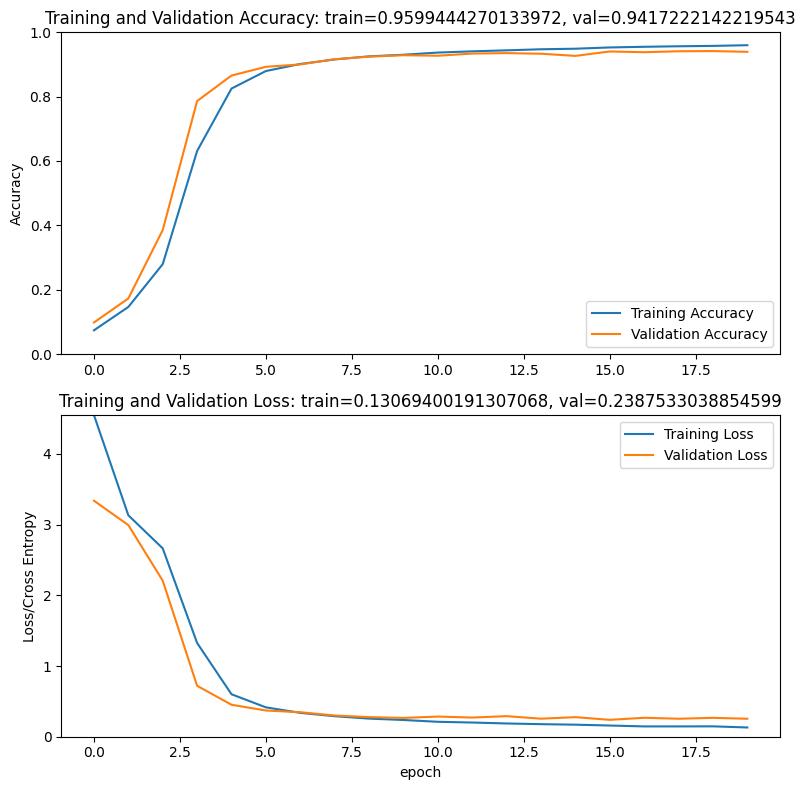

In [37]:
# Plot results and save it to the checkpoint folder
plotting_training_results(history)

In [45]:
# Check that function is correct
i = np.random.permutation(np.arange(len(X_train_selected)))[0]

image_3D = X_train_selected[i]
image_4D = tf.reshape(image_3D, [1, 28, 28, 1])

In [46]:
predictions = model.predict(image_4D)
predictions

1/1 [==============================] - 0s 119ms/step


array([[5.2461866e-37, 1.5018713e-22, 2.3162324e-32, 0.0000000e+00,
        1.4384448e-32, 2.6369584e-25, 4.8869255e-37, 3.0219887e-15,
        4.7729809e-34, 4.4335534e-36, 3.8459806e-34, 6.3179289e-30,
        8.2674516e-25, 1.7572224e-18, 1.3314007e-16, 5.9440222e-09,
        1.2274283e-31, 7.1447374e-25, 5.1125543e-14, 1.1372089e-10,
        5.6876075e-21, 1.2461733e-30, 2.8908246e-24, 1.3255456e-26,
        2.5529991e-27, 5.5490872e-17, 0.0000000e+00, 3.8940985e-31,
        1.0829171e-30, 1.0000000e+00, 1.5932995e-26, 1.1066804e-21,
        3.3824470e-26, 1.2359819e-20, 7.8992043e-13, 8.9417774e-16]],
      dtype=float32)

In [ ]:
index = np.argmax(predictions)
print('index: ', index)

decode_index2numletter = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
                          'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
                          'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 
                          'U', 'V', 'W', 'X', 'Y', 'Z'];
# ----------------------------------------------

# View a sample image
fig, (ax0) = plt.subplots(nrows=1, ncols=1, figsize=(4,4))

ax0.imshow(image_3D)
ax0.axis('off')

ax1.set_title(f"character={decode_index2numletter[index]}", size=12)
plt.show()

# ----------------------------------------------

# Save model files for Tensorflow.js

In [40]:
# Convert the saved model to TensorFlow.js format
tfjs.converters.save_keras_model(model, 'tfjs_model')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [41]:
!cat /kaggle/working/tfjs_model/model.json

{"format": "layers-model", "generatedBy": "keras v2.13.1", "convertedBy": "TensorFlow.js Converter v4.15.0", "modelTopology": {"keras_version": "2.13.1", "backend": "tensorflow", "model_config": {"class_name": "Functional", "config": {"name": "model", "trainable": true, "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 28, 28, 1], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "name": "input_1", "inbound_nodes": []}, {"class_name": "Conv2D", "config": {"name": "conv2d", "trainable": true, "dtype": "float32", "batch_input_shape": [null, 28, 28, 1], "filters": 16, "kernel_size": [3, 3], "strides": [1, 1], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"module": "keras.initializers", "class_name": "HeUniform", "config": {"seed": null}, "registered_name": null}, "bias_initializer": {"module": "keras.initializers", "class_name": "Z

# References

